In [1]:
import string

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import pandas as pd

from tqdm import tqdm
tqdm.pandas()

import joblib

In [2]:
df = pd.read_csv("/content/drive/MyDrive/Colab/ethnicolor/data/contribDB_2014_final.csv")

In [3]:
df['full_name'] = df['contributor.lname'] + ' ' + df['contributor.fname']
df['full_name'] = df['full_name'].str.replace("[^a-zA-Z' -]", '', regex=True)
df['full_name'] = df['full_name'].str.strip()


In [4]:
df.head()

,contributor.lname,contributor.fname,full_name
0,Janet Gray,Hayes,Janet Gray Hayes
1,Thomas M,Dailey,Thomas M Dailey
2,Margaret,Giberson,Margaret Giberson
3,Gregory F,Hooper,Gregory F Hooper
4,William Spencer,Lewis,William Spencer Lewis


In [5]:
vectorizer = joblib.load('/content/drive/MyDrive/Colab/ethnicolor/models_v2/lstm/pt_vec_fullname.joblib')


In [16]:
max_name = 47
all_categories =  ['asian', 'hispanic', 'nh_black', 'nh_white', 'other']
n_categories = len(all_categories)

vocab = list(vectorizer.get_feature_names_out())
all_letters = ''.join(vocab)
n_letters = len(vocab)
oob = n_letters + 1
vocab_size = oob + 1

In [12]:
# A custom Dataset class must implement three functions: __init__, __len__, and __getitem__

class EthniColorDataset(Dataset):
  def __init__(self, data_df, transform=None):
    self.df = data_df
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    name = self.df.iloc[idx, df.columns.get_loc('full_name')]
    if self.transform:
      name_ids = self.transform(name)
    return name, name_ids

In [17]:
def letterToIndex(letter):
    return all_letters.find(letter)

def lineToTensor(line):
    # if name is more than max_name
    if len(line) > max_name:
      line = line[:max_name]
    tensor = torch.ones(max_name) * oob
    for li, letter in enumerate(line):
        tensor[li] = letterToIndex(letter)
    return tensor

In [18]:
dataset = EthniColorDataset(df, lineToTensor)

In [19]:
for i in range(3):
  name, ids  = dataset[i]
  print(i, name, ids)

0 Janet Gray Hayes tensor([12., 29., 42., 33., 48.,  0.,  9., 46., 29., 53.,  0., 10., 29., 53.,
        33., 47., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56.])
1 Thomas M Dailey tensor([22., 36., 43., 41., 29., 47.,  0., 15.,  0.,  6., 29., 37., 40., 33.,
        53., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56.])
2 Margaret Giberson tensor([15., 29., 46., 35., 29., 46., 33., 48.,  0.,  9., 37., 30., 33., 46.,
        47., 43., 42., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56.])


In [20]:
import os

batch_size=1024

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=os.cpu_count())

In [21]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, len(sample_batched[0]), sample_batched[1].size())
    if i_batch == 2:
        break

0 1024 torch.Size([1024, 47])
1 1024 torch.Size([1024, 47])
2 1024 torch.Size([1024, 47])


In [23]:
# Set the random seed for reproducible results
torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # The nn.Embedding layer returns a new tensor with dimension (sequence_length, 1, hidden_size)
        self.embedding = nn.Embedding(input_size, hidden_size)
        # LSTM layer expects a tensor of dimension (batch_size, sequence_length, hidden_size).
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        embedded = self.embedding(input.type(torch.IntTensor).to(input.device))
        # embedded = embedded.view(embedded.shape[0],-1,embedded.shape[3])
        h0 = torch.zeros(self.num_layers, embedded.size(0), self.hidden_size).to(input.device)
        c0 = torch.zeros(self.num_layers, embedded.size(0), self.hidden_size).to(input.device)
        out, _ = self.lstm(embedded, (h0, c0))
        out = out[:, -1, :]  # get the output of the last time step
        out = self.fc(out)
        out = self.softmax(out)
        return out


n_hidden = 256
seq_len = max_name

model = LSTM(vocab_size, n_hidden, n_categories, num_layers=2)
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab/ethnicolor/models_v2/lstm/lstm_fullname.pt', map_location=device))
model.to(device)

LSTM(
  (embedding): Embedding(57, 256)
  (lstm): LSTM(256, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [24]:
# Set the model to evaluation mode
model.eval()

# Disable gradient calculations
with torch.no_grad():
    # List to hold the predictions
    predictions = []
    names = []

    # Loop over the batches
    for batch in tqdm(dataloader):
        # Move the batch to the device the model is on
        nms = list(batch[0])
        tns = batch[1].to(device)
        # Compute the predictions
        outputs = model(tns)
        outputs = torch.argmax(outputs, dim=1)
        # Move the predictions to the CPU and convert to numpy arrays
        outputs = outputs.cpu().numpy()
        # Append the predictions to the list
        predictions.extend(list(outputs))
        names.extend(nms)

100%|██████████| 20825/20825 [10:03<00:00, 34.49it/s]


In [25]:
results_df = pd.DataFrame({'names': names, 'predictions':predictions})

In [26]:
results_df.head()

,names,predictions
0,Ada Lee Correll,2
1,Gary C Johnson,2
2,Bonita B Zdrale,3
3,Sunjay Rajen,3
4,Kimberly Alexander,3


In [27]:
results_df['preds'] = results_df['predictions'].apply(lambda x: all_categories[x])

In [28]:
results_df.head()

,names,predictions,preds
0,Ada Lee Correll,2,nh_black
1,Gary C Johnson,2,nh_black
2,Bonita B Zdrale,3,nh_white
3,Sunjay Rajen,3,nh_white
4,Kimberly Alexander,3,nh_white


In [31]:
results_df.shape

(21324800, 3)

In [32]:
results_df.to_csv("/content/drive/MyDrive/Colab/ethnicolor/data/dime_contrib_2014_results.csv", index=False)

In [33]:
results_df['preds'].value_counts()

nh_white    10531963
nh_black     8325097
asian        1408625
hispanic      947006
other         112109
Name: preds, dtype: int64

In [34]:
res_dict = results_df['preds'].value_counts().to_dict()

<Axes: >

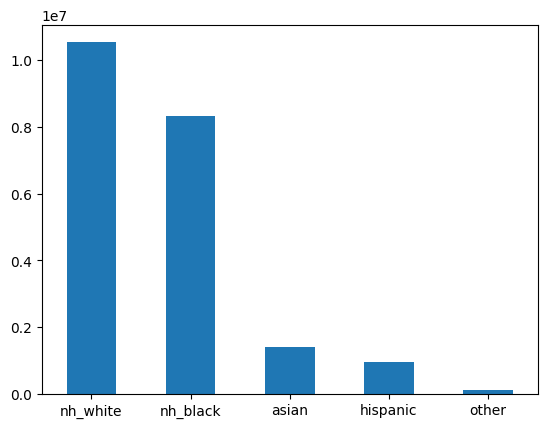

In [35]:
results_df['preds'].value_counts().plot.bar(x='lab', y='val', rot=0)

In [36]:
results_df.shape[0]

21324800

In [37]:
res_dict

{'nh_white': 10531963,
 'nh_black': 8325097,
 'asian': 1408625,
 'hispanic': 947006,
 'other': 112109}

In [38]:
for x in res_dict:
  print(f"{x} - {round(res_dict[x]/results_df.shape[0], 3)}%")

nh_white - 0.494%
nh_black - 0.39%
asian - 0.066%
hispanic - 0.044%
other - 0.005%
